In [2]:
import torch
from tqdm import tqdm, trange
from nnsight import LanguageModel
import plotly.graph_objects as go
#from pyvene import BoundlessRotatedSpaceIntervention
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from datasets import Dataset as hf_Dataset
from transformers import get_linear_schedule_with_warmup, AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
import glob
from einops import einsum, repeat, reduce
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}

In [2]:
# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"  # Just pass string instead of torch.device
full_model_name = 'EleutherAI/gpt-j-6B'
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(
    full_model_name,
    device_map=device,  # or you can use "auto" for automatic device mapping
    torch_dtype=torch.bfloat16,
    dispatch=True,
    trust_remote_code=True  # Add this if you're still getting warnings
)
remote = False
NLAYERS = model.config.num_hidden_layers

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 47.53 GiB of which 14.69 MiB is free. Process 1663678 has 6.98 GiB memory in use. Process 1664812 has 23.93 GiB memory in use. Process 1665837 has 6.98 GiB memory in use. Including non-PyTorch memory, this process has 9.61 GiB memory in use. Of the allocated memory 9.35 GiB is allocated by PyTorch, and 589.50 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Generate and Evaluate
Need to generate math problems and make sure the model can get them right before we move onto any analysis

In [3]:
def ensure_proper_tokenization(mina = 0, maxa = 99):
    # makes sure all numbers are tokenized as 1 token in the range we care about
    ideal_len = 1
    with torch.no_grad():
        for a in range(mina, maxa + 1):
            actual_len = len(model.tokenizer(f'{a}')['input_ids'])
            #actual_len = len([1:])
            if actual_len != ideal_len:
                print(f'WARNING: BAD TOKENIZATION ON {a}')
ensure_proper_tokenization(maxa = 999)

In [1]:
def gen_math(mina = 0, maxa = 99):
    data = []
    with torch.no_grad():
        for a in tqdm(range(mina, maxa + 1)):
            for b in range(mina, maxa + 1):
                q_string = f'Output ONLY a number.\n{a}+{b}='
                q_toks = model.tokenizer(q_string)['input_ids']
                answer = a+b
                answer_tok = model.tokenizer(f'{answer}')['input_ids']
                data.append({
                    'a': a,
                    'b': b,
                    'q_string': q_string,
                    'q_tok': q_toks,
                    'answer': answer,
                    'answer_tok': answer_tok
                })
    df = pd.DataFrame(data)
    df.to_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}.pkl')
    return df

def get_gen_math(mina = 0, maxa = 99):
    return pd.read_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}.pkl')

gen_math(mina = 0, maxa = 99)

NameError: name 'torch' is not defined

In [4]:
def evaluate_math(mina = 0, maxa = 99, verbose = False):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_{mina}_{maxa}.pkl')
    #df = df.sample(n=15, random_state=42)
    correct = []
    rows = []
    for _, row in df.iterrows():
        rows.append(row)
    bar = tqdm(rows)
    with torch.no_grad():
        for row in bar:
            toks = torch.tensor(row['q_tok']).to('cuda')
            with model.trace() as tracer:
                with tracer.invoke(toks) as invoker: # gets the corrupt hs to patch in
                    pass
                output = model.output.save()
            logits = output.logits[:,-1].cpu()
            prediction = logits.argmax(dim=-1).item()
            right = int(prediction == row['answer_tok'][0])
            correct.append(right)
            if not right and verbose:
                print(row['a'], row['b'])
                print(model.tokenizer.batch_decode([prediction]), row['answer'])
            bar.set_postfix({'a+b':f'{row['a']}+{row['b']}', 'ans': row['answer'], 'correct': right, 'percent': f'{np.mean(correct):.3f}'})
    del logits
    df['correct'] = correct
    df.to_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    return np.mean(correct)

def plot_math_results(mina = 0, maxa = 99):    
    model_name = MODEL_NAME
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    
    # Print accuracies for different ranges
    for max_val in [25, 50, 75, 100]:
        filtered_df = df[(df['a'] <= max_val) & (df['b'] <= max_val)]
        acc = 100 * np.mean(filtered_df['correct'])
        print(f"Accuracy for numbers up to {max_val}: {acc:.2f}%")
    
    plt.figure(figsize=(5, 5))
    # Create a scatter plot
    scatter = plt.scatter(df['a'], df['b'], c=df['correct'].replace({1: 1, 0: -1}), cmap='RdBu', s=100, vmin = -2, vmax = 2)
    # Add colorbar
    plt.colorbar(scatter, ticks=[-1, 1], label='Correctness')
    plt.title(f'{model_name} Results on a+b= (Blue if correct)\n{100*np.mean(df['correct']):.2f}% Correct')
    plt.xlabel('a')
    plt.ylabel('b')
    plt.xlim(mina, maxa)
    plt.ylim(mina, maxa)
    plt.grid(True)
    plt.show()

evaluate_math(mina = 0, maxa = 99, verbose = False)
plot_math_results()

  0%|          | 40/10000 [00:02<10:48, 15.36it/s, a+b=0+39, ans=39, correct=1, percent=1.000]


KeyboardInterrupt: 

# Intervention Dataset Generation
We want to use only the prompts we got correct for interventions (to reduce noise, make results meaningful)


In [13]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    return df[df['correct'] == 1]

def gen_intervention(samplesize = 1000, run = False, mina = 0, maxa = 99):
    if run:
        df = get_correct_df(mina = mina, maxa = maxa)
        print(len(df))
        # Drop the 'correct' column since we only have correct examples now
        df = df.drop('correct', axis=1)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        intervention_df = intervention_df[intervention_df['answer_original'] != intervention_df['answer_intervened']]
        # Take random sample of size samplesize
        intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data_addition/data_intervention_{mina}_{maxa}_sample{samplesize}.pkl')
    intervention_df = pd.read_pickle(f'data_addition/data_intervention_{mina}_{maxa}_sample{samplesize}.pkl')
    return intervention_df

df_int = gen_intervention(run = False)

# Layer interventions
Start simple and build up

In [5]:
def calc_logit_diff(patched_logits, og_logits, cor_answer_tokens):
    # Get logit differences between patched and original logits for each answer token
    patched_target =  patched_logits[torch.arange(len(cor_answer_tokens)), cor_answer_tokens]
    og_target = og_logits[torch.arange(len(cor_answer_tokens)), cor_answer_tokens]
    logit_diffs = patched_target - og_target
    return logit_diffs

def calc_correct(patched_logits, cor_answer_tokens):
    # Get logit differences between patched and original logits for each answer token
    patched_answers = patched_logits.argmax(dim=-1)
    return (patched_answers == cor_answer_tokens).to(torch.float)

In [29]:
@torch.no_grad()  
def act_patch(layer, clean_tokens, corrupt_tokens, cor_answer_tokens, patch_type = 'layers'):
    batch_size = len(cor_answer_tokens)
    all_inds = torch.arange(batch_size)
    with model.trace() as tracer:
        with tracer.invoke(clean_tokens) as invoker_clean: # gets the clean tokens for calculation
            pass
        clean_output = model.output.save()
        with tracer.invoke(corrupt_tokens) as invoker_corrupt: # gets the corrupt hs to patch in
            if patch_type == 'layers':
                corrupt_hs = model.transformer.h[layer].output[0].save()
            elif patch_type == 'mlps':
                #corrupt_hs = model.transformer.h[layer].mlp.output.save()
                corrupt_hs = model.transformer.h[layer].mlp.act.input.save()
            elif patch_type == 'attention':
                corrupt_hs = model.transformer.h[layer].attn.output[0].save()
            else:
                raise ValueError(f'Invalid patch type {patch_type}')
    with model.trace(validate = False) as tracer:
        with tracer.invoke(clean_tokens) as invoker_patch: # puts corrupt hs into clean run
            patch_hs = corrupt_hs[all_inds,-1,:].detach().to('cuda')
            if patch_type == 'layers':
                model.transformer.h[layer].output[0][all_inds, -1, :] = patch_hs
            elif patch_type == 'mlps':
                #model.transformer.h[layer].mlp.output[all_inds, -1, :] = patch_hs
                model.transformer.h[layer].mlp.act.input[all_inds, -1, :] = patch_hs
            elif patch_type == 'attention':
                model.transformer.h[layer].attn.output[0][all_inds, -1, :] = patch_hs
        patched_output = model.output.save()
    clean_logits = clean_output.logits[:batch_size,-1].cpu()
    patched_logits = patched_output.logits[:,-1].cpu()
    log_diff = calc_logit_diff(patched_logits, clean_logits, cor_answer_tokens)
    correct = calc_correct(patched_logits, cor_answer_tokens)
    metrics = {'logit_diff':log_diff, 'accuracy': correct}
    return metrics

def act_patch_batch(layer, df, batch_size=8, num_to_use = None, patch_type = 'layers'):
    if num_to_use is not None:
        df = df.sample(n=num_to_use, random_state=42)
    clean_tokens = torch.stack([torch.tensor(x) for x in df['q_tok_original'].values])
    corrupt_tokens = torch.stack([torch.tensor(x) for x in df['q_tok_intervened'].values])
    corrupt_answer_tokens = torch.stack([torch.tensor(x[0]) for x in df['answer_tok_intervened'].values])
    combined_results = None

    for i in range(0, len(clean_tokens), batch_size):
        batch_clean = clean_tokens[i:i+batch_size].to('cuda')
        batch_corrupt = corrupt_tokens[i:i+batch_size].to('cuda') 
        batch_corrupt_answers = corrupt_answer_tokens[i:i+batch_size]
        results = act_patch(layer, batch_clean, batch_corrupt, batch_corrupt_answers, patch_type = patch_type)
        if combined_results is None:
            combined_results = {key:results[key] for key in results.keys()}
        else: 
            combined_results = {key: torch.cat([combined_results[key], results[key]]) for key in combined_results.keys()}
    combined_results = {key: torch.mean(combined_results[key]).item() for key in combined_results.keys()} # take mean at the end
    return combined_results

def act_patch_all(df, patch_type = 'layers', num_to_use = None):
    results = {}
    layers = list(range(NLAYERS))
    bar = tqdm(layers)
    for layer in bar:
        metrics = act_patch_batch(layer, df, num_to_use = num_to_use, patch_type = patch_type)
        results[layer] = metrics
        bar.set_postfix({'layer':layer, **metrics})
    save_data = {
        'results': results,
        'layers': layers
    }
    with open(f'data/act_patching/act_patching_results_all_{patch_type}.pkl', 'wb') as f:
        pickle.dump(save_data, f)
    return results

def plot_act_patch_all(patch_type = 'layers'):
    with open(f'data/act_patching/act_patching_results_all_{patch_type}.pkl', 'rb') as f:
        data = pickle.load(f)
    
    results = data['results'] 
    layers = data['layers']
    
    metrics = list(next(iter(results.values())).keys())
    
    for metric in metrics:
        plt.figure(figsize=(4,3))
        values = [results[layer][metric] for layer in layers]
        plt.plot(layers, values, '-o')
        plt.xlabel('Layer')
        plt.ylabel(metric.replace('_',' ').title())
        plt.title(f'Activation Patching {patch_type}: {metric.replace("_"," ").title()}')
        plt.grid(True)
        plt.savefig(f'figs_addition/act_patching/act_patch_{patch_type}_{metric}.png')
        plt.show()
        plt.close()

for patch_type in ['mlps', 'attention', 'layers']:
    act_patch_all(df_int, num_to_use = 100, patch_type = patch_type)
    plot_act_patch_all(patch_type = patch_type)


 11%|█         | 3/28 [00:06<00:55,  2.22s/it, layer=2, logit_diff=0.0075, accuracy=0] 


KeyboardInterrupt: 

# Attribution Patching
TODO: Patch MLPs in a way that allows me to see how neurons affect it

In [7]:
def attpatch_logit_diff(cor_logits, og_logits, og_answer_tokens):
    # Get logit differences between patched and original logits for each answer token
    indices = torch.arange(len(og_answer_tokens)).to(cor_logits.device)
    cor_target =  cor_logits[indices, og_answer_tokens]
    og_target = og_logits[indices, og_answer_tokens]
    logit_diffs = cor_target #- og_target
    return logit_diffs.mean()

def att_patch(clean_tokens, corrupted_tokens, clean_answer_tokens):
    clean_out = []
    corrupted_out = []
    corrupted_grads = []

    with model.trace() as tracer:
        with tracer.invoke(clean_tokens) as invoker_clean:
            # Gather each layer's attention
            for layer in model.transformer.h:
                mlp = layer.mlp.fc_out.input
                clean_out.append(mlp.save())
            og_logits = model.lm_head.output.save()[:,-1].cpu()
        with tracer.invoke(corrupted_tokens) as invoker_corrupted:
            # Gather each layer's attention and gradients
            for layer in model.transformer.h:
                mlp = layer.mlp.fc_out.input
                corrupted_out.append(mlp.save())
                # save corrupted gradients for attribution patching
                corrupted_grads.append(mlp.grad.save())
            cor_logits = model.lm_head.output.save()[:,-1].cpu()
            value = attpatch_logit_diff(cor_logits, og_logits, clean_answer_tokens)
            value.backward()
    return clean_out, corrupted_out, corrupted_grads


def att_patch_all(df, batch_size = 8):
    clean_tokens = torch.stack([torch.tensor(x) for x in df['q_tok_original'].values])
    corrupt_tokens = torch.stack([torch.tensor(x) for x in df['q_tok_intervened'].values])
    clean_answer_tokens = torch.stack([torch.tensor(x[0]) for x in df['answer_tok_original'].values])

    total_samples = len(clean_tokens)
    num_batches = (total_samples + batch_size - 1) // batch_size  # Ceiling division
    total_results = None

    for batch in tqdm(range(num_batches)):
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, total_samples)  # Handle final partial batch
        
        batch_clean = clean_tokens[start_idx:end_idx]
        batch_corrupt = corrupt_tokens[start_idx:end_idx] 
        batch_answers = clean_answer_tokens[start_idx:end_idx]

        clean_mlps, corrupt_mlps, corrupt_grads = att_patch(batch_clean, batch_corrupt, batch_answers)

        batch_results = []
        for corrupted_grad, corrupted, clean, layer in zip(
            corrupt_grads, corrupt_mlps, clean_mlps, range(len(clean_mlps))
        ):
                
            res = (corrupted_grad.value * (clean.value - corrupted.value))[:,-1].detach().cpu().float()
            # Sum over batch dimension
            summed_res = res.sum(dim=0)
            batch_results.append(summed_res)

        batch_results = torch.stack(batch_results)
        if total_results is None:
            total_results = batch_results
        else:
            total_results += batch_results

        del corrupt_grads, corrupt_mlps, clean_mlps

    # Divide by actual total number of samples processed
    total_results = total_results / num_batches # not total_num bc of how gradients are accumulated
    return total_results

total_results = att_patch_all(df_int)

100%|██████████| 125/125 [00:54<00:00,  2.28it/s]


## Plotting the results of attribution patching and sanity checking MLP

tensor(2.1245)


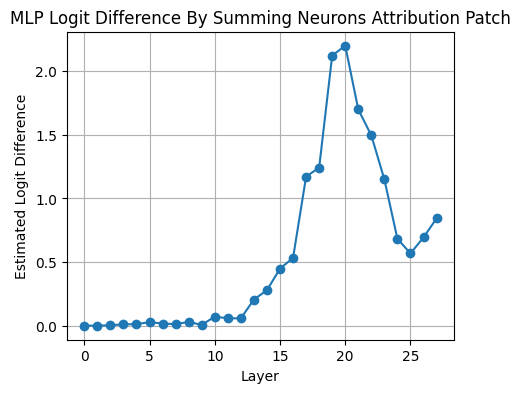

In [9]:
def plot_mlp_attpatch(total_results):
    layers = list(range(total_results.shape[0]))
    print(total_results[19].sum())
    att_patch_logdiff = []
    for layer in layers:
        att_patch_logdiff.append(total_results[layer].sum())
    plt.figure(figsize = (5,4))
    plt.plot(layers, att_patch_logdiff, marker = 'o')
    plt.title('MLP Logit Difference By Summing Neurons Attribution Patch')
    plt.xlabel('Layer')
    plt.ylabel('Estimated Logit Difference')
    plt.grid()
    plt.savefig('figs_addition/att_patch_mlp_estimate.png')
    plt.show()

def plot_neurons_attpatch(total_results):
    layers = list(range(total_results.shape[0]))
    att_patch_logdiff = []
    for layer in layers:
        neuron_indices = range(total_results[layer].shape[0])
        plt.figure(figsize=(5,4))
        plt.scatter(neuron_indices, total_results[layer].numpy())
        plt.title(f'MLP Neuron Attribution Patch Values - Layer {layer}')
        plt.xlabel('Neuron Index')
        plt.ylabel('Estimated Logit Difference')
        plt.grid()
        plt.savefig(f'figs_addition/att_patching_neurons/layer{layer}_attribution_dist.png')
        #plt.show()
        plt.close()

plot_mlp_attpatch(total_results)
plot_neurons_attpatch(total_results)

## Creating df with layer, neuron_idx, logit_difference 

In [3]:
def create_neuron_df(total_results):
    # Create lists to store data
    layers = []
    neuron_indices = []
    logit_diffs = []
    
    # Extract data from total_results
    for layer in range(total_results.shape[0]):
        for neuron_idx in range(total_results[layer].shape[0]):
            layers.append(layer)
            neuron_indices.append(neuron_idx)
            logit_diffs.append(float(total_results[layer][neuron_idx]))
    
    # Create dataframe
    df = pd.DataFrame({
        'layer': layers,
        'neuron_idx': neuron_indices, 
        'logit_difference': logit_diffs
    })
    df.to_csv('data_addition/neuron_att_patching.csv', index=False)
    
    return df

def get_sorted_neuron_df():
    df = pd.read_csv('data_addition/neuron_att_patching.csv')
    df = df.sort_values('logit_difference', ascending=False)
    return df

def plot_neuron_impact_acrosslayers():
    df = pd.read_csv('data_addition/neuron_att_patching.csv')
    df = df.sort_values('logit_difference', ascending=False)
    
    # Calculate percentile ranks
    total_neurons = len(df)
    percentiles = [(i+1)/total_neurons * 100 for i in range(total_neurons)]
    
    plt.figure(figsize=(6,4))
    scatter = plt.scatter(percentiles,
                         df['logit_difference'], 
                         c=df['layer'],
                         cmap='viridis',
                         alpha=0.5)
    plt.xscale('log')
    plt.colorbar(scatter, label='Layer')
    plt.title('Neuron Impact on Logit Difference Across Layers')
    plt.xlabel('Percentile (Top %)')
    plt.ylabel('Logit Difference')
    plt.grid(alpha=0.3)
    plt.savefig('figs_addition/neuron_impact_acrosslayers.png', dpi=300, bbox_inches='tight')
    plt.show()

#create_neuron_df(total_results)
#plot_neuron_impact_acrosslayers()

# Putting neurons back into model to see if we recover performance

In [4]:
@torch.no_grad()
def calc_mlp_meanablation(batch_size = 8, num_to_use = 100):
    df = get_gen_math()
    df = df.sample(n=num_to_use, random_state=42)
    tokens = torch.stack([torch.tensor(x) for x in df['q_tok'].values])
    mlps_total = []
    for i in tqdm(range(0, len(tokens), batch_size)):
        batch_tokens = tokens[i:i+batch_size].to('cuda')
        mlps = []
        with model.trace() as tracer:
            with tracer.invoke(batch_tokens) as invoker_clean:
                for layer in range(NLAYERS):
                    mlp = model.transformer.h[layer].mlp.fc_out.input.save()
                    mlps.append(mlp)
        mlps_total.append(mlps)
    mean_mlp_activations = torch.stack([
        torch.mean(torch.cat([batch[layer][:,-1,:].cpu() for batch in mlps_total]), dim=0)
        for layer in range(NLAYERS)
    ])

    print(f"Shape of mean MLP activations: {mean_mlp_activations.shape}")
    # Save tensor to file
    torch.save(mean_mlp_activations, 'data_addition/mean_mlp_activations.pt')
    del mlps, mlps_total
    #return mlps_total
def get_mlp_meanablation():
    return torch.load('data_addition/mean_mlp_activations.pt')

calc_mlp_meanablation()
mlps_total = get_mlp_meanablation()


100%|██████████| 13/13 [00:01<00:00, 10.73it/s]


Shape of mean MLP activations: torch.Size([28, 16384])


/tmp/ipykernel_3917763/209883952.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load('data_addition/mean_mlp_activations.pt')


In [72]:
@torch.no_grad()  
def get_topk_neurons(k):
    df = get_sorted_neuron_df()
    top_k = df.head(k)
    # Initialize list of lists for each layer
    layer_neurons = [[] for _ in range(NLAYERS)]  # 28 layers based on context
    # Group neurons by layer
    for _, row in top_k.iterrows():
        layer = int(row['layer'])
        neuron = int(row['neuron_idx'])
        layer_neurons[layer].append(neuron)  
    return layer_neurons
    
def topk_neuron_ablate(k = 1, batch_size=8, num_to_use=100, verbose = False):
    # Randomly sample num_to_use rows from df
    df = get_correct_df()
    df = df.sample(n=num_to_use, random_state=42)
    neurons_layers = get_topk_neurons(k)

    tokens = torch.stack([torch.tensor(x) for x in df['q_tok'].values])
    answer_tokens = torch.stack([torch.tensor(x) for x in df['answer_tok'].values])[:,0]
    
    mlps_ablated_all = get_mlp_meanablation()
    
    all_correct = []
    all_logit_diffs = []

    with torch.no_grad():
        for i in range(0, len(tokens), batch_size):
            
            batch_tokens = tokens[i:i+batch_size].to(device)
            batch_answers = answer_tokens[i:i+batch_size]
            mlps_ablated = mlps_ablated_all.unsqueeze(1).expand(-1, batch_tokens.shape[0], -1)
            mlp_outs = []
            with model.trace() as tracer:
                with tracer.invoke(batch_tokens) as invoker_clean:
                    for layer in range(NLAYERS):
                        mlp_out = model.transformer.h[layer].mlp.fc_out.input.save()
                        mlp_outs.append(mlp_out)
                og_logits = model.lm_head.output.save()
            mlps = torch.stack([mlp_out[:,-1] for mlp_out in mlp_outs])
            # Create tensor with same shape as mlps
            insert = torch.zeros_like(mlps)
            # Fill with ablated values initially
            insert.copy_(mlps_ablated)
            # For each layer, copy over the specified neuron values from mlps
            for layer_idx, neuron_indices in enumerate(neurons_layers):
                if neuron_indices:  # Only process if there are neurons for this layer
                    insert[layer_idx, :, neuron_indices] = mlps[layer_idx, :, neuron_indices]
            with model.trace() as tracer:
                with tracer.invoke(batch_tokens) as invoker_clean:
                    for layer in range(NLAYERS):
                        model.transformer.h[layer].mlp.fc_out.input[:,-1] = insert[layer]
                patched_logits = model.lm_head.output.save()
            
            patched_logits = patched_logits[:,-1].cpu()
            og_logits = og_logits[:,-1].cpu()
            model_answers = patched_logits.argmax(dim=-1)
            correct = (model_answers == batch_answers).float()
            logit_diff = og_logits[torch.arange(len(batch_answers)), batch_answers] - patched_logits[torch.arange(len(batch_answers)), batch_answers]
            incorrect_indices = model_answers != batch_answers
            if incorrect_indices.any() and verbose:
                print('Incorrect predictions:')
                print('Model answers:', model.tokenizer.batch_decode(model_answers[incorrect_indices]))
                print('Actual answers:', model.tokenizer.batch_decode(batch_answers[incorrect_indices]))
            all_correct.append(correct)
            all_logit_diffs.append(logit_diff.float())
            # Clean up variables
            del mlps_ablated, batch_tokens, batch_answers, og_logits, patched_logits, model_answers, correct
            torch.cuda.empty_cache()
            
        
    results = {'correct': torch.cat(all_correct), 'log_diff': torch.cat(all_logit_diffs)}
    # Clean up remaining variables
    del tokens, answer_tokens, all_correct, all_logit_diffs, neurons_layers, df
    torch.cuda.empty_cache()

    
    return results
topk_neuron_ablate(k=1000, num_to_use = 100)['correct'].mean()

/tmp/ipykernel_3917763/209883952.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load('data_addition/mean_mlp_activations.pt')


tensor(0.5400)

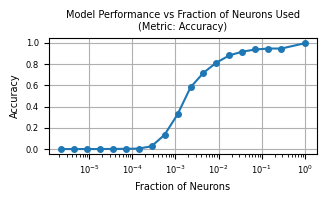

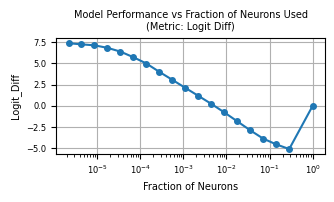

,k,frac_neurons,accuracy,logit_diff
0,1,0.000002,0.001,7.367656
1,2,0.000004,0.001,7.235125
2,4,0.000009,0.001,7.120438
3,8,0.000017,0.001,6.823406
4,16,0.000035,0.002,6.380844
5,32,0.000070,0.003,5.717250
6,64,0.000140,0.005,4.979187
7,128,0.000279,0.027,3.993750
8,256,0.000558,0.135,3.057625
9,512,0.001116,0.326,2.111500


In [5]:
def accuracy_neurons_used(run = True):
    maxk = len(get_sorted_neuron_df())
    if run:
        results = []
        ks = [2**i for i in range(int(np.log2(maxk)))]
        ks.append(maxk)
        for k in tqdm(ks):
            res = topk_neuron_ablate(k=k, num_to_use=1000)
            results.append({
                'k': k,
                'frac_neurons': k/maxk,
                'accuracy': res['correct'].mean().item(),
                'logit_diff': res['log_diff'].mean().item()
            })
        df = pd.DataFrame(results)
        df.to_csv('data_addition/neurons_vs_metrics.csv', index=False)
    df = pd.read_csv('data_addition/neurons_vs_metrics.csv')
    
    for metric in ['accuracy', 'logit_diff']:
        plt.figure(figsize=(3.25,2))
        plt.semilogx(df['frac_neurons'], df[metric], 'o-', markersize=4)
        plt.xlabel('Fraction of Neurons')
        plt.ylabel(metric.title())
        plt.title(f'Model Performance vs Fraction of Neurons Used\n(Metric: {metric.replace("_", " ").title()})')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'figs_addition/neurons_vs_{metric}.png', bbox_inches = 'tight', dpi = 300)
        plt.show()
        plt.close()
    
    return df
    #topk_neuron_ablate(k=1000, num_to_use = 100)['correct'].mean()
accuracy_neurons_used(run = False)